In [27]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

**注意：**

In PaddlePaddle 2.x, we turn on dynamic graph mode by default, and 'data()' is only supported in static graph mode. So if you want to use this api, please call 'paddle.enable_static()' before this api to enter static graph mode.

In [28]:
BUF_SIZE=500
BATCH_SIZE=20

# paddle.enable_static()
#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  

In [29]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

# 此处使用均方差损失函数
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

# 采用SGD进行优化
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [30]:
test_program = fluid.default_main_program().clone(for_test=True)

# 模型训练 and 模型评估

**（1）创建Executor**

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

In [31]:

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #进行参数初始化

# DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。
# feed_list设置向模型输入的向变量表或者变量表名
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

**（3）定义绘制训练过程的损失值变化趋势的方法draw_train_process**

In [32]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

**（4）训练并保存模型**

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。 feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

注：enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，

Pass:0, Cost:514.28424
Test:0, Cost:522.98218
Pass:1, Cost:449.76465
Test:1, Cost:117.43137
Pass:2, Cost:698.90936
Test:2, Cost:195.56226
Pass:3, Cost:457.79657
Test:3, Cost:271.29446
Pass:4, Cost:470.76236
Test:4, Cost:87.38360
Pass:5, Cost:561.95642
Test:5, Cost:65.89394
Pass:6, Cost:364.28754
Test:6, Cost:140.84135
Pass:7, Cost:306.92780
Test:7, Cost:106.41085
Pass:8, Cost:527.26892
Test:8, Cost:25.16078
Pass:9, Cost:258.05524
Test:9, Cost:24.85291
Pass:10, Cost:429.43701
Test:10, Cost:140.87563
Pass:11, Cost:313.80984
Test:11, Cost:66.29125
Pass:12, Cost:410.19012
Test:12, Cost:12.18373
Pass:13, Cost:274.09302
Test:13, Cost:123.00557
Pass:14, Cost:245.03159
Test:14, Cost:49.73233
Pass:15, Cost:156.77896
Test:15, Cost:75.58055
Pass:16, Cost:157.24438
Test:16, Cost:37.00494
Pass:17, Cost:260.69165
Test:17, Cost:61.77635
Pass:18, Cost:201.52559
Test:18, Cost:0.76834
Pass:19, Cost:81.95564
Test:19, Cost:28.40631
Pass:20, Cost:103.46721
Test:20, Cost:30.91426
Pass:21, Cost:89.46706
Test

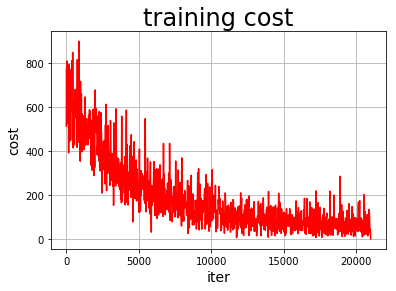

In [33]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)

In [34]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

**（2）可视化真实值与预测值方法定义**

In [35]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

infer results: (House Price)
0: 14.33
1: 14.61
2: 14.28
3: 16.43
4: 15.04
5: 15.89
6: 15.18
7: 15.01
8: 12.16
9: 14.78
10: 11.32
11: 13.55
12: 14.35
13: 13.63
14: 13.52
15: 14.90
16: 16.30
17: 16.10
18: 16.44
19: 14.56
20: 15.29
21: 13.79
22: 15.84
23: 15.17
24: 15.05
25: 14.41
26: 15.79
27: 15.68
28: 16.76
29: 15.56
30: 15.33
31: 14.60
32: 14.76
33: 13.39
34: 12.83
35: 15.25
36: 15.31
37: 16.02
38: 16.29
39: 16.10
40: 14.56
41: 14.15
42: 15.96
43: 16.30
44: 16.18
45: 15.83
46: 15.11
47: 16.40
48: 16.47
49: 16.99
50: 14.91
51: 15.22
52: 14.60
53: 14.87
54: 16.23
55: 16.78
56: 16.31
57: 16.92
58: 17.03
59: 17.47
60: 17.56
61: 17.26
62: 15.15
63: 16.08
64: 16.82
65: 17.46
66: 17.23
67: 17.75
68: 17.76
69: 18.29
70: 16.14
71: 15.67
72: 16.84
73: 15.02
74: 16.55
75: 17.25
76: 18.41
77: 18.89
78: 19.14
79: 18.57
80: 17.98
81: 18.46
82: 17.37
83: 18.08
84: 17.18
85: 16.16
86: 15.20
87: 17.38
88: 18.21
89: 22.31
90: 22.44
91: 22.03
92: 20.75
93: 21.86
94: 22.21
95: 21.55
96: 21.83
97: 23.12
9

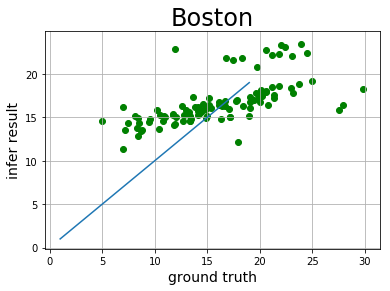

In [36]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据

    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)